In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis
from sklearn.metrics import confusion_matrix
import vbmfa.fa as vbfa
import mord
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from plot_confusion import *

In [2]:
df = pd.read_csv('data/train.csv')
df_val = pd.read_csv('data/val.csv')

In [3]:
music = df.iloc[:,:19]
movies = df.iloc[:,19:31]
interests = df.iloc[:,31:63]
personality = df.iloc[:,63:]

music_val = df_val.iloc[:,:19]
movies_val = df_val.iloc[:,19:31]
interests_val = df_val.iloc[:,31:63]
personality_val = df_val.iloc[:,63:]


In [4]:
data = {'music':music,'movies':movies,'interests':interests,'personality':personality}
data_val = {'music':music_val,'movies':movies_val,'interests':interests_val,'personality':personality_val}


In [5]:
pca_proj = {}
pca_proj_val = {}

for k in data.keys():
    # Train
    means = np.mean( data[k] , axis = 0 )
    scaled = data[k] - means
    pca = PCA()
    pca.fit(scaled)
    projected = pca.transform(scaled)
    pca_proj[k] = projecteda
    
    # Validation
    
    scaled_val = data_val[k] - means
    pca_proj_val[k] = pca.transform(scaled_val)
    
    

In [6]:
# Threshholding

#First principal component

y_train , bins_train = pd.qcut( pca_proj['personality'][:,0]  , q = 5, labels = [1,2,3,4,5] , retbins=True)
y_val = pd.cut( pca_proj_val['personality'][:,0] , bins_train , right=True, labels=[1,2,3,4,5] )

y_train = np.array(y_train)
y_val = np.array(y_val)

x_train = np.concatenate( [ pca_proj['interests'][:,:10] , pca_proj['music'][:,:5] , pca_proj['movies'][:,:4]   ], axis=1)
x_val = np.concatenate( [ pca_proj_val['interests'][:,:10] , pca_proj_val['music'][:,:5] , pca_proj_val['movies'][:,:4]   ], axis=1)


## Ordinal Logistic Regression

### All-Threshold variant


 Training classification
Confusion matrix, without normalization
[[35 63 32 12  0]
 [ 9 56 50 24  2]
 [ 6 28 71 33  5]
 [ 2 16 51 57 13]
 [ 0 14 43 54 31]]


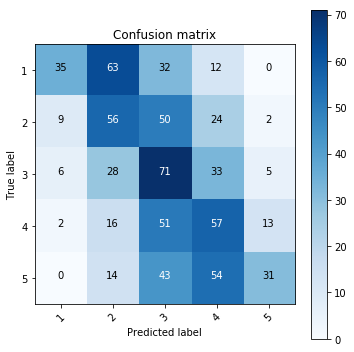


 Validation classification
Confusion matrix, without normalization
[[11 32 11  3  1]
 [ 7 20 20  9  1]
 [ 4  7 26 14  2]
 [ 0 10 14 20  6]
 [ 0  4  8 17  5]]


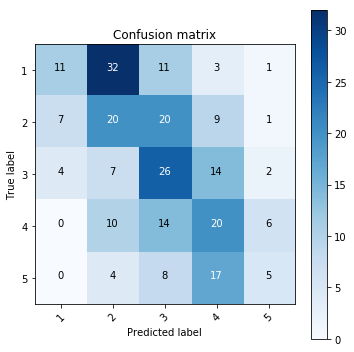

In [7]:
ord_logit = mord.LogisticAT(alpha=1.0)
ord_logit.fit(X = x_train, y = y_train )
y_pred = ord_logit.predict(x_train)
y_pred_val = ord_logit.predict(x_val)

print '\n Training classification'
plot_confusion_matrix( confusion_matrix( y_train , y_pred ) , classes=[1,2,3,4,5] ,size = 5)

print '\n Validation classification'
plot_confusion_matrix( confusion_matrix( y_val , y_pred_val ) , classes=[1,2,3,4,5] ,size = 5)


In [8]:
## AUC
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html


from sklearn import metrics

train_auc = []
val_auc = []


for i in [1,2,3,4,5]:
    fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred , pos_label=i)
    train_auc.append( metrics.auc(fpr, tpr) )
    
    fpr, tpr, thresholds = metrics.roc_curve(y_val, y_pred_val , pos_label=i)
    val_auc.append( metrics.auc(fpr, tpr) ) 

In [9]:
print 'Train AUC per class'
print train_auc
print 'Validatoin AUC per class'
print val_auc

Train AUC per class
[0.22125763430138351, 0.38510262386286742, 0.50809031394137771, 0.65531588813456276, 0.7320578337280319]
Validatoin AUC per class
[0.23564699608958409, 0.39644624381466487, 0.56053854176543094, 0.67277227722772281, 0.73502428494333516]


# Ordinal Regression with FA Decomposition

In [12]:
fa_proj = {}
fa_proj_val = {}

for k in data.keys():
    # Train
    means = np.mean( data[k] , axis = 0 )
    scaled = data[k] - means
    fa = FactorAnalysis()
    fa.fit(scaled)
    projected = fa.transform(scaled)
    fa_proj[k] = projected
    
    # Validation
    
    scaled_val = data_val[k] - means
    fa_proj_val[k] = fa.transform(scaled_val)
    
    

In [17]:
# Threshholding

#First principal component

y_train , bins_train = pd.qcut( fa_proj['personality'][:,0]  , q = 5, labels = [1,2,3,4,5] , retbins=True)
y_val = pd.cut( fa_proj_val['personality'][:,0] , bins_train , right=True, labels=[1,2,3,4,5] )

y_train = np.array(y_train)
y_val = np.array(y_val)

x_train = np.concatenate( [ fa_proj['interests'][:,:10] , fa_proj['music'][:,:5] , fa_proj['movies'][:,:4]   ], axis=1)
x_val = np.concatenate( [ fa_proj_val['interests'][:,:10] , fa_proj_val['music'][:,:5] , fa_proj_val['movies'][:,:4]   ], axis=1)



 Training classification
Confusion matrix, without normalization
[[13 80 37 12  0]
 [ 5 46 59 30  1]
 [ 5 33 59 41  3]
 [ 1 25 65 43  7]
 [ 4 17 41 54 26]]


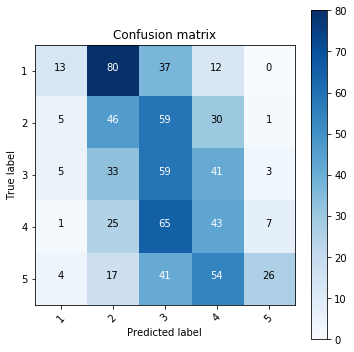


 Validation classification
Confusion matrix, without normalization
[[ 7 14 20  6  0]
 [ 2 20 15 12  3]
 [ 2 17 19 11  0]
 [ 0  7 27 11  5]
 [ 1  2 11 36  4]]


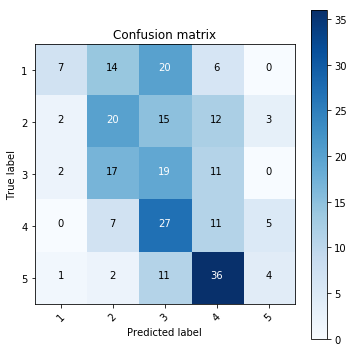

In [18]:
ord_logit = mord.LogisticAT(alpha=1.0)
ord_logit.fit(X = x_train, y = y_train )
y_pred = ord_logit.predict(x_train)
y_pred_val = ord_logit.predict(x_val)

print '\n Training classification'
plot_confusion_matrix( confusion_matrix( y_train , y_pred ) , classes=[1,2,3,4,5] ,size = 5)

print '\n Validation classification'
plot_confusion_matrix( confusion_matrix( y_val , y_pred_val ) , classes=[1,2,3,4,5] ,size = 5)


In [19]:
## AUC
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html


from sklearn import metrics

train_auc = []
val_auc = []


for i in [1,2,3,4,5]:
    fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred , pos_label=i)
    train_auc.append( metrics.auc(fpr, tpr) )
    
    fpr, tpr, thresholds = metrics.roc_curve(y_val, y_pred_val , pos_label=i)
    val_auc.append( metrics.auc(fpr, tpr) ) 

In [20]:
print 'Train AUC per class'
print train_auc
print 'Validatoin AUC per class'
print val_auc

Train AUC per class
[0.25727907266608502, 0.44281758263789683, 0.51908377816204287, 0.58157281407412986, 0.69947650504798697]
Validatoin AUC per class
[0.32148417228853138, 0.42615384615384616, 0.4010757012164472, 0.56257425742574252, 0.7656191545080433]


# Ordinal Regression with VFA Decomposition

In [37]:
np.random.seed(302)
vfa_proj = {}
vfa_proj_val = {}

for k in data.keys():
    train_len = data[k].shape[0]
    # concat train and val
    concat = np.concatenate( [ data[k],data_val[k] ], axis=0)
    print(concat.shape)
    means = np.mean( concat , axis = 0 )
    scaled = concat - means
    
    vfa = vbfa.VbFa( scaled.T )
    vfa.fit(maxit = 500)
    
    projected = vfa.q_x.mean
    vfa_proj[k] = projected.T[:train_len]
    vfa_proj_val[k] =  projected.T[train_len:]
    print(vfa_proj[k].shape)
    print(vfa_proj_val[k].shape)
    


(959, 32)
(707, 32)
(252, 32)
(959, 12)
(707, 12)
(252, 12)
(959, 19)
(707, 19)
(252, 19)
(959, 54)
(707, 54)
(252, 54)


In [38]:
# Threshholding

#First principal component

y_train , bins_train = pd.qcut( vfa_proj['personality'][:,0]  , q = 5, labels = [1,2,3,4,5] , retbins=True)
y_val = pd.cut( vfa_proj_val['personality'][:,0] , bins_train , right=True, labels=[1,2,3,4,5] )
#fill in nan with average
y_val[np.where(np.isnan(y_val))]=3

y_train = np.array(y_train)
y_val = np.array(y_val)

x_train = np.concatenate( [ vfa_proj['interests'][:,:10] , vfa_proj['music'][:,:5] , vfa_proj['movies'][:,:4]   ], axis=1)
x_val = np.concatenate( [ vfa_proj_val['interests'][:,:10] , vfa_proj_val['music'][:,:5] , vfa_proj_val['movies'][:,:4]   ], axis=1)



 Training classification
Confusion matrix, without normalization
[[ 0 55 71 15  1]
 [ 1 29 86 25  0]
 [ 0 23 91 25  2]
 [ 0 14 91 38  0]
 [ 0 17 82 40  1]]


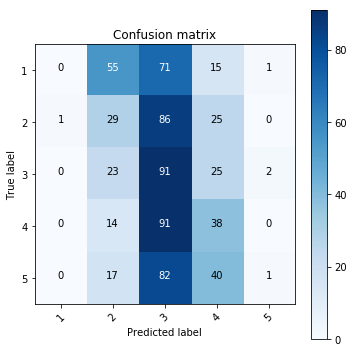


 Validation classification
Confusion matrix, without normalization
[[ 0 15 22  4  0]
 [ 0 19 19  8  1]
 [ 0 21 38 11  1]
 [ 0  5 30 13  0]
 [ 0  7 25 13  0]]


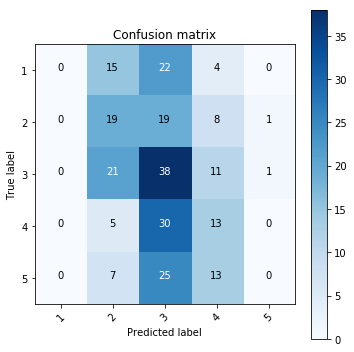

In [39]:
ord_logit = mord.LogisticAT(alpha=1.0)
ord_logit.fit(X = x_train, y = y_train )
y_pred = ord_logit.predict(x_train)
y_pred_val = ord_logit.predict(x_val)

print '\n Training classification'
plot_confusion_matrix( confusion_matrix( y_train , y_pred ) , classes=[1,2,3,4,5] ,size = 5)

print '\n Validation classification'
plot_confusion_matrix( confusion_matrix( y_val , y_pred_val ) , classes=[1,2,3,4,5] ,size = 5)


In [40]:
## AUC
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html


from sklearn import metrics

train_auc = []
val_auc = []


for i in [1,2,3,4,5]:
    fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred , pos_label=i)
    train_auc.append( metrics.auc(fpr, tpr) )
    
    fpr, tpr, thresholds = metrics.roc_curve(y_val, y_pred_val , pos_label=i)
    val_auc.append( metrics.auc(fpr, tpr) ) 

In [41]:
print 'Train AUC per class'
print train_auc
print 'Validatoin AUC per class'
print val_auc

Train AUC per class
[0.35846940047363829, 0.47533393479187031, 0.50962960178432704, 0.57725784853444428, 0.57966742252456538]
Validatoin AUC per class
[0.40596462836666281, 0.42895692786715101, 0.46739553342152362, 0.609375, 0.59082125603864721]
